# A. Feature Diagnostics

## A0 Common setup

*(run once for setup before other cells)*

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_theme(style="whitegrid")

DIST = Path("data/sessions_dist.csv") # winsorised + z-scaled 8-feature table
df_dist = pd.read_csv(DIST)

features8 = [
    "grip_ratio", "accuracy", "score_per_throw", "throws_per_s",
    "hand_movement", "head_movement", "yaw_range", "pitch_range"
]

X8 = df_dist[features8].values # numpy matrix for diagnostics
print(f"Loaded: {DIST}   |   shape = {X8.shape}")

Loaded: data\sessions_dist.csv   |   shape = (151, 8)


## A1 Eight-feature scree plot

PCA scree containing eigenvalues and cumulative variance for 8 features

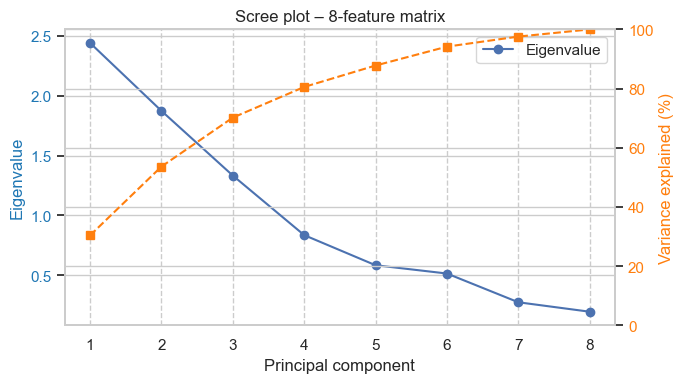

In [9]:
pca8 = PCA().fit(X8)
eig  = pca8.explained_variance_
cumvar = np.cumsum(pca8.explained_variance_ratio_) * 100  # %

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(range(1, len(eig)+1), eig, marker="o", label="Eigenvalue")
ax1.set_xlabel("Principal component"); ax1.set_ylabel("Eigenvalue", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue"); ax1.grid(True, axis="x", linestyle="--")

ax2 = ax1.twinx()
ax2.plot(range(1, len(cumvar)+1), cumvar, marker="s", linestyle="--",
         color="tab:orange", label="Cumulative variance")
ax2.set_ylabel("Variance explained (%)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange"); ax2.set_ylim(0, 100)

ax1.legend(loc="best")
plt.title("Scree plot – 8-feature matrix")
plt.tight_layout(); plt.show()

## A2 Per-feature variance contribution (PC 1-3)

Sum of squared loadings on PCs 1-3

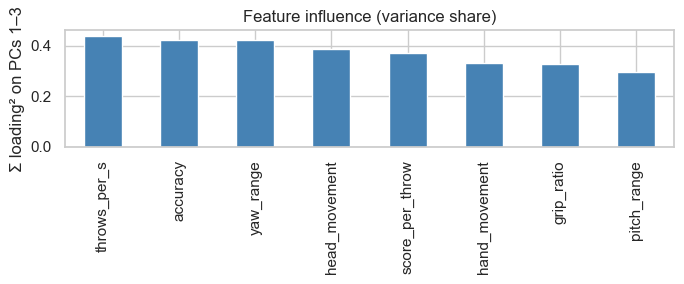

,PC1-3 influence
throws_per_s,0.439
accuracy,0.423
yaw_range,0.421
head_movement,0.389
score_per_throw,0.371
hand_movement,0.330
grip_ratio,0.329
pitch_range,0.298


In [19]:
loading_sq = (pca8.components_[:3] ** 2).sum(axis=0)
influence  = pd.Series(loading_sq, index=features8).sort_values(ascending=False)

influence.plot(kind="bar", figsize=(7,3), color="steelblue")
plt.ylabel("Σ loading² on PCs 1–3"); plt.title("Feature influence (variance share)")
plt.tight_layout(); plt.show()

display(influence.round(3).to_frame("PC1-3 influence"))

## A3 Correlation heat-map

Pearson correlation between the eight features

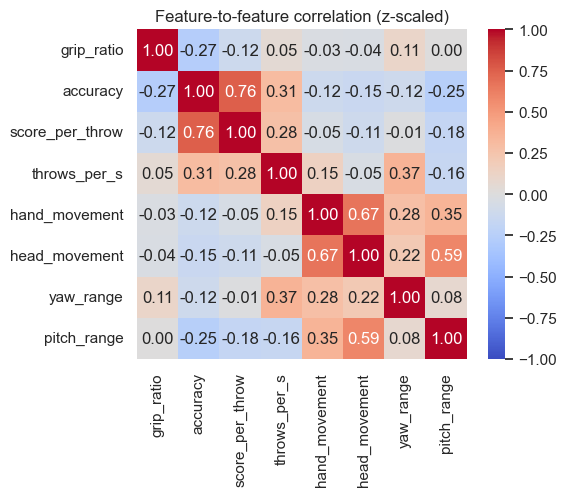

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(df_dist[features8].corr(), annot=True, fmt=".2f",
            cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Feature-to-feature correlation (z-scaled)"); plt.tight_layout(); plt.show()

## A4 Yaw / pitch outlier check

Identify extreme orientation values


yaw_range  five-number summary:
min   -6.44
25%    0.19
50%    0.20
75%    0.20
max    0.20
Name: yaw_range, dtype: float64

pitch_range  five-number summary:
min   -2.00
25%   -0.69
50%    0.03
75%    0.88
max    1.79
Name: pitch_range, dtype: float64


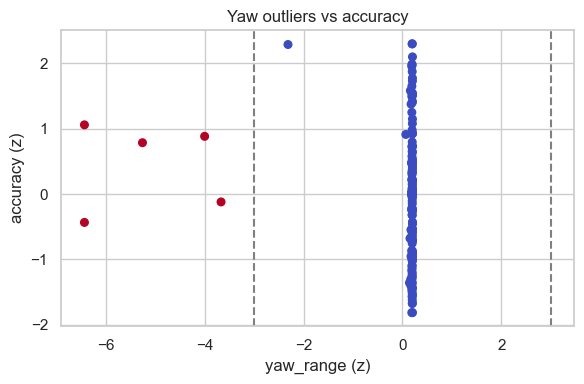

In [21]:
for col in ["yaw_range", "pitch_range"]:
    desc = df_dist[col].describe().round(2)
    print(f"\n{col}  five-number summary:")
    print(desc[["min","25%","50%","75%","max"]])

# Scatter yaw vs accuracy, marking |z| > 3 as red
z_yaw = df_dist["yaw_range"]
plt.figure(figsize=(6,4))
plt.scatter(z_yaw, df_dist["accuracy"], c=(np.abs(z_yaw)>3), cmap="coolwarm", s=30)
plt.axvline(3, ls="--", color="grey"); plt.axvline(-3, ls="--", color="grey")
plt.xlabel("yaw_range (z)"); plt.ylabel("accuracy (z)")
plt.title("Yaw outliers vs accuracy"); plt.tight_layout(); plt.show()

## A5 Silhouette curve for k = 2...6

Silhouette of k on the original eight-feature space

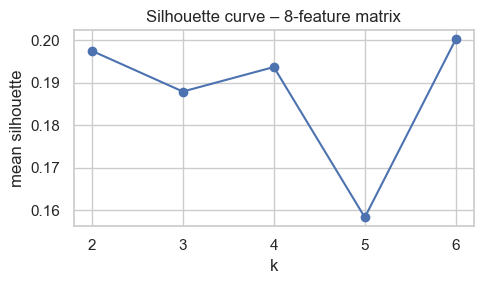

2    0.198
3    0.188
4    0.194
5    0.158
6    0.200
dtype: float64


In [22]:
k_vals, sil = [], []
for k in range(2, 7):
    labels = KMeans(k, random_state=42).fit_predict(X8)
    sil.append(silhouette_score(X8, labels))
    k_vals.append(k)

plt.figure(figsize=(5,3))
plt.plot(k_vals, sil, marker="o")
plt.xlabel("k"); plt.ylabel("mean silhouette")
plt.title("Silhouette curve – 8-feature matrix")
plt.grid(True); plt.tight_layout(); plt.show()

print(pd.Series(np.round(sil,3), index=k_vals))

# B. Feature-set comparison

We assume Cell A0 has already loaded `df_dist`, `features8` and `X8`.

## B0 Silhouette helper

*(Run once at the top of Section B)*

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def silhouette_curve(X, k_min=2, k_max=6):
    """Return list of mean silhouettes for k in [k_min, k_max]."""
    return [silhouette_score(X, KMeans(k, random_state=42).fit_predict(X))
            for k in range(k_min, k_max+1)]

## B1 Six-feature matrix (added head_movement)

In [4]:
features6 = ["grip_ratio", "accuracy", "score_per_throw",
             "throws_per_s", "hand_movement", "head_movement"]

X6 = df_dist[features6].values
sil6 = silhouette_curve(X6)
print("Silhouette 6-feature:", np.round(sil6, 3))

Silhouette 6-feature: [0.211 0.203 0.225 0.217 0.216]


# B2. Five-feature set (main choice)

In [5]:
features5 = ["grip_ratio", "accuracy", "score_per_throw",
             "throws_per_s", "hand_movement"]

X5 = df_dist[features5].values
sil5 = silhouette_curve(X5)
print("Silhouette 5-feature:", np.round(sil5, 3))

Silhouette 5-feature: [0.234 0.239 0.249 0.229 0.224]


## B3. Auto-selected top-5 features (highest PC influence)

In [6]:
pca8 = PCA().fit(X8)
influence = (pca8.components_[:3]**2).sum(axis=0)
top5_idx  = np.argsort(-influence)[:5]
features5_auto = [features8[i] for i in top5_idx]

X5a = df_dist[features5_auto].values
sil5a = silhouette_curve(X5a)
print("Silhouette auto 5-feature:", np.round(sil5a, 3))
print("Auto-selected features →", features5_auto)

Silhouette auto 5-feature: [0.29  0.32  0.246 0.272 0.238]
Auto-selected features → ['throws_per_s', 'accuracy', 'yaw_range', 'head_movement', 'score_per_throw']


## B4. Side-by-side comparison plot

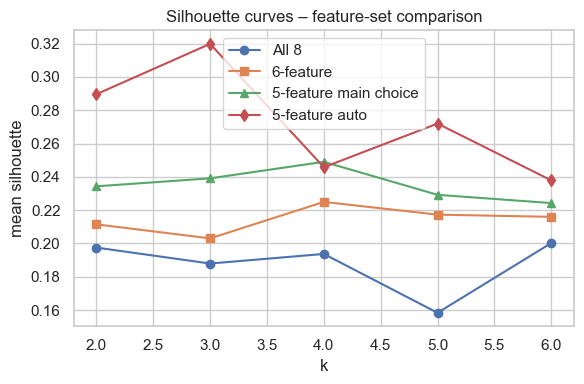

In [8]:
k_vals = list(range(2, 7))
plt.figure(figsize=(6,4))
plt.plot(k_vals, silhouette_curve(X8),    marker="o", label="All 8")
plt.plot(k_vals, sil6,                    marker="s", label="6-feature")
plt.plot(k_vals, sil5,                    marker="^", label="5-feature main choice")
plt.plot(k_vals, sil5a,                   marker="d", label="5-feature auto")
plt.xlabel("k"); plt.ylabel("mean silhouette")
plt.title("Silhouette curves – feature-set comparison")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# C. Alternative k tests (5-feature main)



## C0 Baseline labels (k = 4)

*(run once at the top of Section C)*

In [11]:
from sklearn.cluster import KMeans

km4 = KMeans(n_clusters=4, random_state=42).fit(X5)
labels_k4 = km4.labels_
df_dist["cluster_k4"] = labels_k4          # keep for reference
print("Baseline silhouette (k=4):", round(silhouette_score(X5, labels_k4), 3))

Baseline silhouette (k=4): 0.249


## C1 Alternative k solutions (3, 5, 6)

In [15]:
alt_k   = [3, 5, 6]
labels_alt = {} #store for ARI comparison

for k in alt_k:
    km = KMeans(k, random_state=42).fit(X5)
    sil = round(silhouette_score(X5, km.labels_),3)
    counts = np.bincount(km.labels_)
    labels_alt[k] = km.labels_
    print(f"k={k}  |  silhouette = {sil}  |  sizes = {counts.tolist()}")

k=3  |  silhouette = 0.239  |  sizes = [41, 65, 45]
k=5  |  silhouette = 0.229  |  sizes = [35, 25, 39, 30, 22]
k=6  |  silhouette = 0.224  |  sizes = [15, 33, 26, 28, 22, 27]


## C2 Centroid comparison table

Comparing mean score & accuracy across k values

In [14]:
def centroid(df, labels, metrics):
    df_tmp = df.copy()
    df_tmp["c"] = labels
    return df_tmp.groupby("c")[metrics].mean().round(1)

metrics = ["score", "accuracy"]
print("\nCentroids (k=3):")
display(centroid(df_dist, labels_alt[3], metrics))
print("\nCentroids (k=4)  *baseline*:")
display(centroid(df_dist, labels_k4, metrics))
print("\nCentroids (k=5):")
display(centroid(df_dist, labels_alt[5], metrics))
print("\nCentroids (k=6):")
display(centroid(df_dist, labels_alt[6], metrics))


Centroids (k=3):


,score,accuracy
c,,
0,3590.5,0.4
1,999.4,-0.8
2,3530.4,0.8



Centroids (k=4)  *baseline*:


,score,accuracy
c,,
0,3658.9,0.4
1,822.0,-0.5
2,3669.0,0.8
3,1097.6,-1.0



Centroids (k=5):


,score,accuracy
c,,
0,3837.1,0.5
1,1382.6,-0.7
2,3779.7,0.9
3,1361.3,-0.9
4,633.0,-0.3



Centroids (k=6):


,score,accuracy
c,,
0,4090.0,1.0
1,1908.0,-0.4
2,4477.9,1.3
3,969.8,-1.1
4,646.8,-0.4
5,3293.1,0.1


## C3 Adjusted Rand Index vs baseline (k = 4)

In [18]:
from sklearn.metrics import adjusted_rand_score

for k in alt_k:
    ari = round(adjusted_rand_score(labels_k4, labels_alt[k]),3)
    print(f"ARI  k=4 vs k={k}:  {ari}")

ARI  k=4 vs k=3:  0.722
ARI  k=4 vs k=5:  0.683
ARI  k=4 vs k=6:  0.537


# D. Soft-membrship diagnostics

## D1 Posterior probabilities & histograms

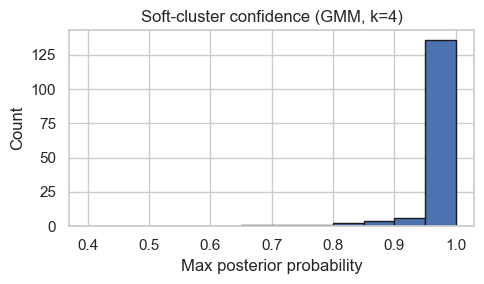

Median max posterior = 0.997


In [19]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

gmm = GaussianMixture(n_components=4, covariance_type="full",
                      random_state=42, n_init=10).fit(X5)
post = gmm.predict_proba(X5)              # n × 4
max_post = post.max(axis=1)               # confidence of assignment

# Histogram of max posteriors
plt.figure(figsize=(5,3))
plt.hist(max_post, bins=np.linspace(0.4, 1.0, 13), edgecolor="k")
plt.xlabel("Max posterior probability"); plt.ylabel("Count")
plt.title("Soft-cluster confidence (GMM, k=4)")
plt.tight_layout(); plt.show()

print(f"Median max posterior = {np.median(max_post):.3f}")

## D2 Borderline sessions (posterior < 0.60)

In [20]:
threshold = 0.60
border_idx = np.where(max_post < threshold)[0]
print(f"{len(border_idx)} sessions have max posterior < {threshold}")

df_border = df_dist.iloc[border_idx].copy()
df_border["gmm_max_post"] = max_post[border_idx]
display(df_border[["cluster_k4", "gmm_max_post"] + features5].head())


0 sessions have max posterior < 0.6


,cluster_k4,gmm_max_post,grip_ratio,accuracy,score_per_throw,throws_per_s,hand_movement


# E. Robustness & sensitivity

## E1 Noise-perturbation stability (ARI)

In [21]:
from sklearn.metrics import adjusted_rand_score

def ari_noise(X, labels, runs=10, noise=0.05):
    ari_vals = []
    rng = np.random.default_rng(42)
    for _ in range(runs):
        Xn = X * (1 + rng.uniform(-noise, noise, X.shape))
        new_labels = KMeans(4, random_state=0).fit_predict(Xn)
        ari_vals.append(adjusted_rand_score(labels, new_labels))
    return np.mean(ari_vals), np.min(ari_vals)

sets = {
    "5-feature": X5,
    "6-feature": X6,
    "8-feature": X8
}

for name, Xm in sets.items():
    mean_ari, min_ari = ari_noise(Xm, labels_k4)
    print(f"{name:<9}  ARI mean = {mean_ari:.3f}  |  min = {min_ari:.3f}")

5-feature  ARI mean = 0.800  |  min = 0.624
6-feature  ARI mean = 0.534  |  min = 0.441
8-feature  ARI mean = 0.511  |  min = 0.263


## E2 Silhouette check for k = 3 and k = 5 (five-feature matrix)

In [22]:
for k in (3, 5):
    sil = silhouette_score(X5, KMeans(k, random_state=42).fit_predict(X5))
    print(f"Silhouette 5-feature, k={k}: {sil:.3f}")


Silhouette 5-feature, k=3: 0.239
Silhouette 5-feature, k=5: 0.229


# F. Visualization

## F0. Common plotting function (run once)

In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def tsne_plot(X, labels, title, perplexity=28):
    ts = TSNE(n_components=2, init="pca", perplexity=perplexity,
              learning_rate="auto", random_state=42)
    emb = ts.fit_transform(X)
    plt.figure(figsize=(6,4))
    for c in sorted(np.unique(labels)):
        idx = labels == c
        plt.scatter(emb[idx,0], emb[idx,1], s=25, label=f"C{c}")
    plt.title(title); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

## F1. t-SNE on original 8-feature space (k = 4)

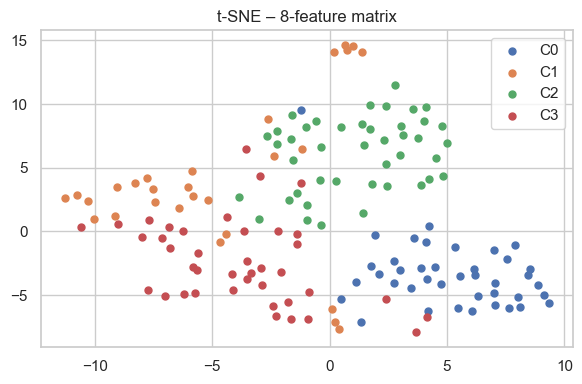

In [30]:
tsne_plot(X8, labels_k4, title="t-SNE – 8-feature matrix")

## F2. t-SNE on the 6-feature matrix (k = 4)

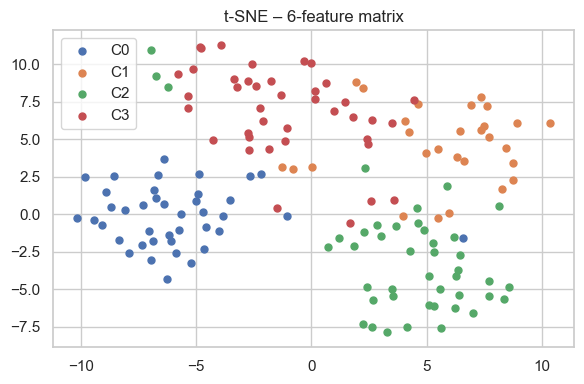

In [29]:
tsne_plot(X6, labels_k4, title="t-SNE – 6-feature matrix")

## F3. t-SNE on 5-feature matrix (main one used)

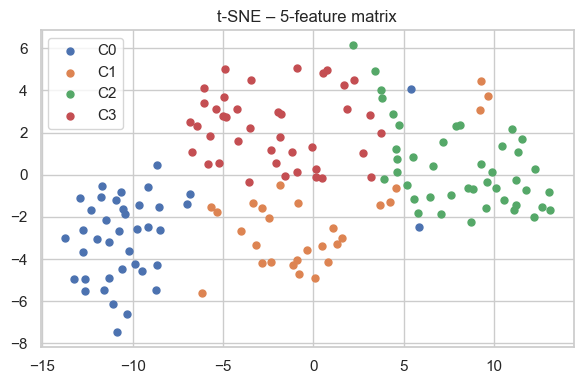

In [28]:
tsne_plot(X5, labels_k4, title="t-SNE – 5-feature matrix")